# Results Analysis

This notebook is intended to read a simulation results file and report the analysis.

In [1]:
%matplotlib inline

import os
import sys 
import json
import networkx as nx
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from networkx.readwrite import json_graph
from datetime import date
from collections import defaultdict, Counter
from operator import itemgetter
from itertools import groupby, chain
from copy import deepcopy 

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.results import Results
from cloudscope.viz import draw_topology
from cloudscope.viz import plot_workload
from cloudscope.viz import plot_message_traffic
from cloudscope.utils.timez import epochptime

matplotlib.style.use('ggplot')

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Specify a path to a results file 
FIXTURES = os.path.join("..", "fixtures", "results")
# RESULTS  = os.path.join(FIXTURES, "raft-quorum-20160411.json")
# RESULTS  = os.path.join(FIXTURES, "tagging-quorum-20160411.json")
RESULTS  = os.path.join("..", "raft-quorum-20160615.json")

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        return Results.load(f)

# Load the data
results = get_results_data()

In [3]:
def title(text):
    return " ".join([t.capitalize() for t in text.split("_")])

def report_details():
    banner = (
        "Simulation: {} (Cloudscope v{})\n"
        "{}\n\n"
        "Ran on: {} ({})\n\n"
        "Settings\n"
        "========\n"
    ).format(
        results.simulation, results.version, results.topology['meta']['description'],
        epochptime(results.timer['started']).strftime('%b %d, %Y at %H:%M %Z'), 
        results.timer['elapsed'],
        results.randseed,
    )
    
    longest = max(len(key) for key in results.settings)
    frmt = "{{: <{0}}} {{: >12}}".format(longest)
    
    
    return banner + "\n".join([
        frmt.format(title(key), value)
        for key, value in results.settings.items()
    ])
    

def report_topology():
    topology = deepcopy(results.topology)
    nodes = topology['nodes']
    links = topology['links']
    
    for link in links:
        latency = [link['latency']] if link['connection'] == 'constant' else link['latency']
        
        for rid in ('source', 'target'):
            node = nodes[link[rid]]
            
            if 'minlat' not in node:
                node['minlat'] = latency[0]
            else:
                
                node['minlat'] = min(node['minlat'], latency[0])

            if 'maxlat' not in node:
                node['maxlat'] = latency[-1]
            else:
                node['maxlat'] = max(node['maxlat'], latency[-1])
         
    output = []
    for node in sorted(nodes, key=itemgetter('id')):
        output.append(
            "{}: {} ({}, {}) {}-{}ms connection".format(
                node['id'], node['label'], node['location'], node['consistency'], node['minlat'], node['maxlat']
            )
        )
    return "\n".join(output)

In [4]:
def create_dataframe():
    
    # Handlers for various rows: return a dictionary to add to data frame. 
    def default_handler(key, values):
        return {
            key: len(values) 
        }
    
    def handle_visibility_latency(key, values):
        return {
            "mean visibility latency (ms)": sum(v[2] - v[1] for v in values) / len(values), 
            "visible writes": len(set([v[1] for v in values]))
        }
    
    def handle_commit_latency(key, values):
        return {
            "mean commit latency (ms)": sum(v[2] - v[1] for v in values) / len(values),
            "committed writes": len(set([v[1] for v in values]))
        }

    def handle_session_length(key, values):
        return {
            "sessions": len(values), 
            "mean session duration (ms)": sum(v[0] for v in values) / len(values),
        }

    def handle_read_latency(key, values):
        return {
            "completed reads": len(values), 
            "mean read latency (ms)": sum(v[2] - v[1] for v in values) / len(values),
        }

    def handle_write_latency(key, values):
        return {
            "completed writes": len(values),
            "mean write latency (ms)": sum(v[2] - v[1] for v in values) / len(values),
        }
    
    def handle_tag_size(key, values):
        return {
            "average tag size": sum(v[1] for v in values) / len(values)
        }
    
    def rename_key(name, func=default_handler):
        def handle_rename(key, values):
            item = func(key, values)
            return {
                name: item[key]
            }
        return handle_rename
        

    # Handler map 
    handlers = {
        'visibility latency': handle_visibility_latency, 
        'commit latency': handle_commit_latency, 
        'session length': handle_session_length,
        'read latency': handle_read_latency,
        'write latency': handle_write_latency, 
        'tag size': handle_tag_size,
        'read': rename_key('reads'),
        'write': rename_key('writes'),
    }
    
    replicas = defaultdict(lambda: defaultdict(list)) 
    topology = results.topology
    config   = results.settings
    series   = results.results
    
    # Extract per-replica ID values from all results series 
    for key, values in series.iteritems():
        for value in values:
            # Some quick checks 
            assert len(value) > 1 
            assert value[0].startswith('r')
            
            # Append the series to the specific replica 
            replicas[value[0]][key].append(value[1:])
    
    # Create a table with each replica id
    table = []
    for replica, series in replicas.iteritems():
        row = {'replica': replica} 
        
        # Perform per-replica aggreations for each result set 
        for serie, values in series.iteritems():
            handler = handlers.get(serie, default_handler)
            row.update(handler(serie, values))
        
        # Add in topology information 
        
        
        table.append(row)
    
    # Create the data frame and compute aggregate dependency items 
    df = pd.DataFrame(sorted(table, key=itemgetter('replica')))
    df['missed reads'] = df['reads'] - df['completed reads']
    df['dropped writes'] = df['writes'] - df ['visible writes']
    df['visibility ratio'] = df['visible writes'] / df['writes']
    
    return df

df = create_dataframe()
df 

,committed writes,completed reads,completed writes,empty reads,mean commit latency (ms),mean read latency (ms),mean visibility latency (ms),mean write latency (ms),reads,recv,replica,sent,stale reads,visible writes,writes,missed reads,dropped writes,visibility ratio
0,653,943,653,6,169.655739,0,143.067683,59.811639,949,29455,r0,29455,20,653,653,6,0,1.000000
1,643,921,644,7,164.870729,0,138.675076,59.810559,928,29443,r1,29443,11,643,644,7,1,0.998447
2,618,923,618,3,169.492774,0,143.203130,60.875405,926,29417,r2,29417,10,618,618,3,0,1.000000
3,660,948,660,5,139.229388,0,114.712721,0.000000,953,117839,r3,117843,6,660,660,5,0,1.000000
4,730,982,731,4,167.166914,0,140.735407,60.678523,986,29530,r4,29530,19,730,731,4,1,0.998632


# Results 

In [5]:
print report_details()

Simulation: Raft Quorum (Cloudscope v0.3)
Single Consistency Type: Strong Raft Consensus.

Ran on: Jun 15, 2016 at 19:25 UTC (28 seconds)

Settings
Access Stddev                 512
Do Rumoring                     0
Access Mean                  1600
Move Prob                     0.2
Max Objects Accessed           10
Do Gossip                       1
Max Sim Time              4320000
Random Seed                    42
Switch Prob                   0.6
Election Timeout       [300, 600]
Heartbeat Interval            150
Default Consistency        strong
Invalid Types         [u'backup']
Aggregate Heartbeats            1
Read Prob                    0.58
Aggregate Writes                1
Default Latency               800
Anti Entropy Delay          10000
Object Prob                   0.3
Valid Locations      [u'home', u'work', u'mobile', u'cloud']
Session Timeout             40960
Default Replica           storage
Count Messages                  1
Synchronous Access              0
Users    

## Topology

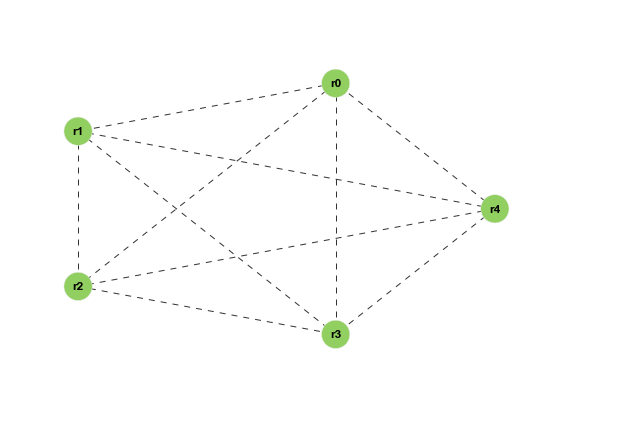

In [6]:
draw_topology(json_graph.node_link_graph(results.topology))

In [7]:
print report_topology()

r0: Raft 1 (cloud, strong) 15-45ms connection
r1: Raft 2 (cloud, strong) 15-45ms connection
r2: Raft 3 (cloud, strong) 15-45ms connection
r3: Raft 4 (cloud, strong) 15-45ms connection
r4: Raft 5 (cloud, strong) 15-45ms connection


## Workload

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

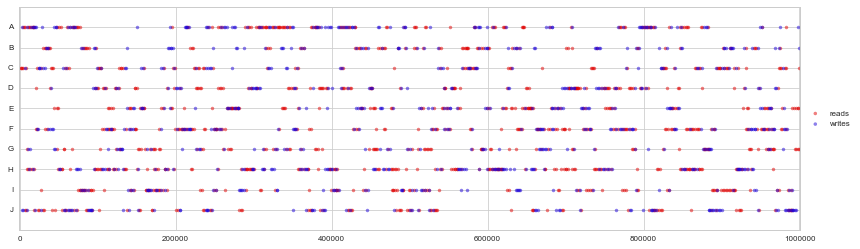

In [8]:
# Create the workload timeline plot 
plot_workload(results, series='objects')

In [9]:
# Create the sent messages timeline
# plot_message_traffic(results.results['sent'])

In [10]:
# Create Message Traffic Data Frame 
columns = ['replica', 'timestamp', 'type', 'latency']

def messages():
    for key in ('sent', 'recv'):
        for message in results.results[key]:
            msg = dict(zip(columns, message))
            msg['recv'] = 1 if key == 'recv' else 0
            msg['sent'] = 1 if key == 'sent' else 0
            yield msg

def count(nums):
    return sum(nums)
            
msgs = pd.DataFrame(messages())

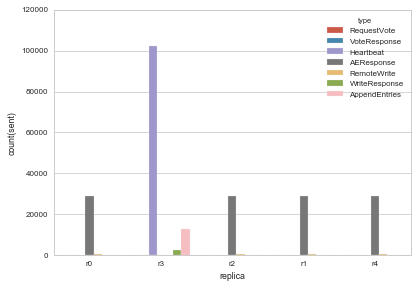

In [11]:
ax = sns.barplot(y='sent', x='replica', hue='type', data=msgs, estimator=count)

## Metrics 

The following metrics are reported from the results.

### Reads and Writes

Accesses
4742 Total Reads, 3306 Total Writes 
948.4 average reads per replica
661.2 average writes per replica



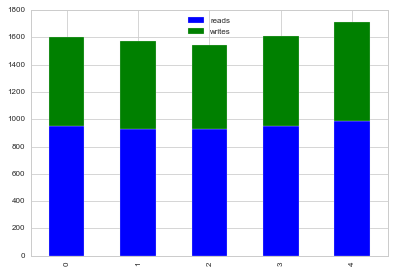

In [12]:
# Extract accesses 
accesses = pd.DataFrame(df, columns=['reads', 'writes'])

print (
    "Accesses\n"
    "========\n"
    "{} Total Reads, {} Total Writes \n"
    "{:0.1f} average reads per replica\n"
    "{:0.1f} average writes per replica\n"
).format(
    df.reads.sum(), df.writes.sum(), df.reads.mean(), df.writes.mean()
)

accesses.plot(kind='bar', stacked=True)

### Stale Reads

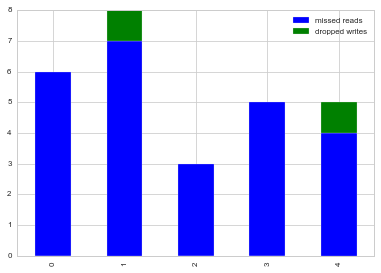

In [13]:
errors = pd.DataFrame(df, columns=['missed reads', 'dropped writes'])
errors.plot(kind='bar', stacked=True)

### Read and Write Costs

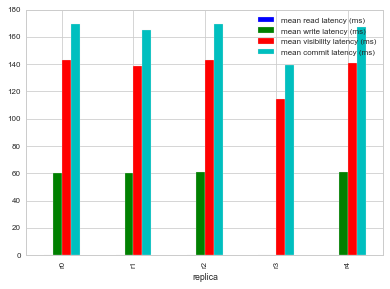

In [14]:
data=pd.DataFrame(df, columns=['replica', 'mean read latency (ms)', 'mean write latency (ms)', 'mean visibility latency (ms)', 'mean commit latency (ms)'])
data.plot(kind='bar', x='replica')